# Proyek Machine Learning-Sistem Rekomendasi Film

## Latar Belakang
Pada era digital dimana arus informasi dan data bergerak dengan sangat cepat, pengguna internet kerap kali dihadapkan pada banuaknya pilihan konten dalam hal hiburan seperti film. Dengan banyaknya film yang tersedia, kerap kali pengguna merasa kesulitan dalam menentukan film yang cocok dengannya.

Pengalaman pengguna menjadi faktor yang sangat penting untuk menarik pelanggan agar mereka dapat menemukan informasi yang mereka inginkan dengan mudah. Ketika pengguna tidak menemukan informasi atau produk yang dimaksud, mereka akan beralih pada aplikasi lain atau bahkan menceritakan pengalaman buruk mereka kepada orang lain.

Melalui proyek ini, dikembangkan sistem rekomendasi film dengan pendekatan content based filtering yang melibatkan preferensi pengguna berdasarkan genre dan collaboratife filtering yang memanfaatkan data rating untuk memprediksi preferensi pengguna terhadap film lain.

## Problem statement
Berdasarkan latar belakang yang sudah disampaikan, terdapat beberapa rumusan masalah yang akan diselesaikan pada proyek ini:
1. Bagaimana cara membangun sistem rekomendasi dengan algoritma content-based filtering berdasarkan genre?
2. Bagaimana cara membangun sistem rekomendasi dengan algoritma collaborative filtering berdasarkan?
3. Bagaimana kinerja dari algoritma content-based filtering dan collaborative filtering yang dibuat?

## Goals
1. Mengetahui cara membangun sistem rekomendasi dengan algoritma content-based filtering berdasarkan genre.
2. Mengetahui cara membangun sistem rekomendasi dengan algoritma collaborative filtering berdasarkan aktivitas rating yang diberikan pengguna.
3. Mengetahui kinerja dari algoritma content-based filtering dan collaborative filtering yang dibuat

## Solution Statement
1. Membangun sistem rekomendasi dengan algoritma content-based filtering, dalam proyek ini akan memanfaatkan informasi fitur genre. Setiap film akan direpresentasikan dengan vektor fitur TF-IDF, dan rekomendasi diberikan berdasarkan kemiripan antara film yang dipilih menggunakan metrik mesamaan cosine similarity.
2. Membangun sistem rekomendasi dengan algoritma collaborative filtering menggunakan pendekatab berbasis model machine learning dengan memanfaatkan data rating pengguna terhadap film.
3. Melakukan pengujian menggunakan metrik Precision untuk menguji kinerja alogritma content-based filtering dan menggunakan metrik Root Mean Square Error (RMSE) pada collaborative filtering.


# Import Library yang Digunakan

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from tensorflow import keras
from tensorflow.keras import layers

# Load kaggle api

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwilarassetyadita","key":"fe6de741a875da33d1ae5d355ed183bd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Data Understanding

## Load Dataset

In [ ]:
!kaggle datasets download -d nicoletacilibiu/movies-and-ratings-for-recommendation-system -p /kaggle

Dataset URL: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system
License(s): CC0-1.0
  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 1.08GB/s]


In [ ]:
!unzip /kaggle/movies-and-ratings-for-recommendation-system.zip -d /kaggle

Archive:  /kaggle/movies-and-ratings-for-recommendation-system.zip
  inflating: /kaggle/movies.csv      
  inflating: /kaggle/ratings.csv     


In [ ]:
# konversi data movies ke dalam dataframe
movies_df = pd.read_csv('/kaggle/movies.csv', on_bad_lines='skip')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


insight :
- Setiap film dikategorikan ke dalam beberapa genre sekaligus.

In [ ]:
# konversi data ratings ke dalam dataframe
ratings_df = pd.read_csv('/kaggle/ratings.csv', on_bad_lines='skip')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# cek jumlah data
print('Jumlah data movies: ',len(movies_df.movieId.unique()))
print('Jumlah data user: ',len(ratings_df.userId.unique()))

Jumlah data movies:  9742
Jumlah data user:  610


## Exploratory Data Analysis

### Deskripsi Variabel

In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


insight :
- terdapat 9742 baris data di dalam dataset
- data terdiri dari 3 kolom yaitu : movieId, title, dan genres.
- terdapat 1 data bertipe int64 yaitu kolom movieId, dan 2 kolom bertipe object yaitu kolom title dan genres

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


insight
Data Movies terdiri dari 100.836 baris data dan 4 kolom, yang merepresentasikan beberapa informasi mengenai rating film.
- userId : menyimpan data id unik pengguna.
- movieId : menyimpan data id unik film.
- rating : 	Nilai rating yang diberikan pengguna terhadap film (dalam skala 0.5 – 5.0).
- timestamp :Menyimpan waktu (dalam format UNIX timestamp) saat rating diberikan.

In [ ]:
movies_df.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


insight
- fitur movieId memiliki rentang antara 1-193609, ini menunjukkan bahwa id film tidak berurutan dan memiliki banyak celah di dalam penomoran id.
- Data memiliki nilai median= 7300 dan nilai mean= 42200 yang menandakan distribusi data movieId cenderong ke kanan(right-skewed)

In [ ]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


insight
- Nilai movieId memiliki sebaran yang sangat luas, dari 1 hingga 193.609, dengan rata-rata sekitar 19.435 dan standar deviasi yang besar. Hal ini menunjukkan bahwa penomoran ID film tidak berurutan secara padat.
- Data rating, memiliki nilai dalam rentang 0.5 hingga 5, dengan rata-rata 3.5 dan distribusi yang hampir simetris.

### Missing Value, Outlier, Data Duplikat

#### Missing Value

In [ ]:
missing_values_movie = movies_df.isnull().sum()
print('jumlah missing value pada data movie: ', missing_values_movie)

missing_values_rating = ratings_df.isnull().sum()
print('jumlah missing value pada data rating: ', missing_values_rating)

jumlah missing value pada data movie:  movieId    0
title      0
genres     0
dtype: int64
jumlah missing value pada data rating:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


insight :
- tidak ditemukan missing value di dalam data

#### Memeriksa Outlier

melakukan visualisasi data ratings dengan boxplot

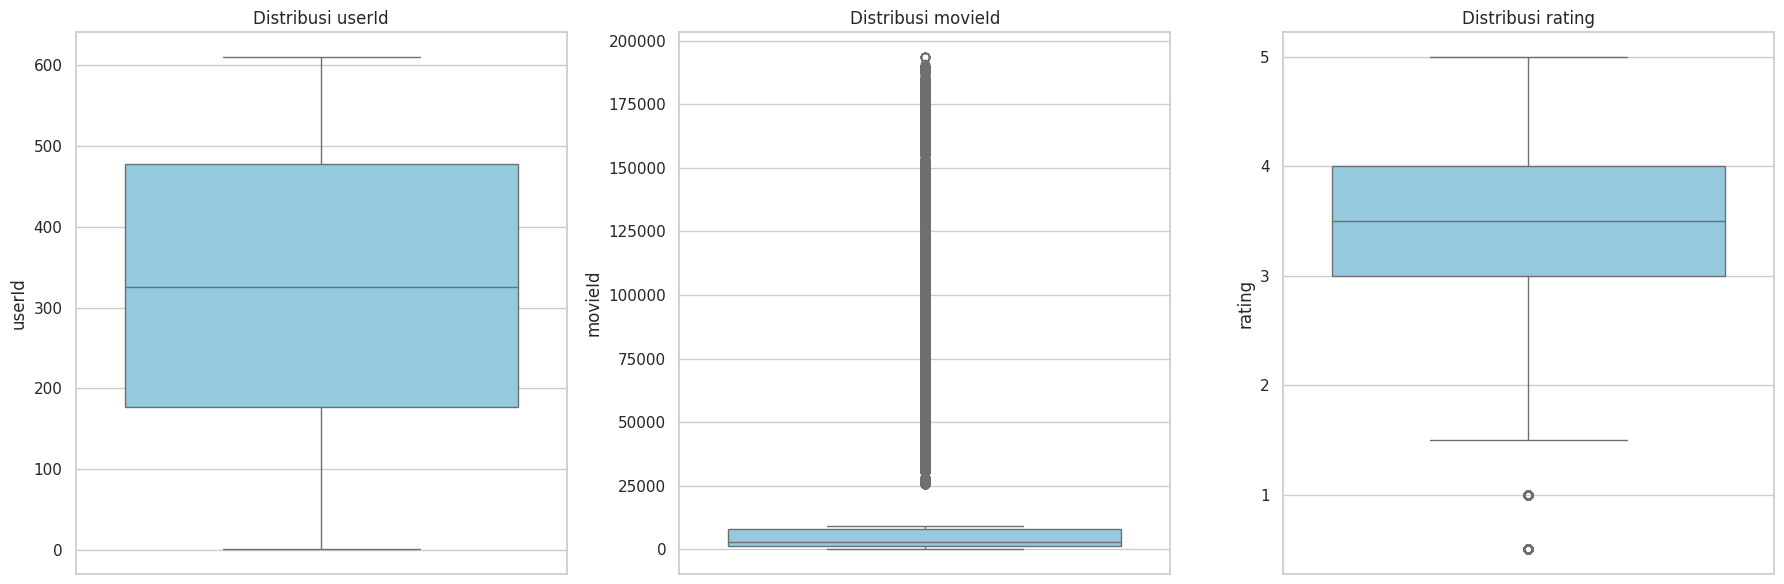

In [ ]:
cols = ['userId', 'movieId', 'rating']

# Set gaya visual
sns.set(style="whitegrid")

# Buat subplot 1 baris 3 kolom
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop setiap kolom dan buat boxplot-nya
for i, col in enumerate(cols):
    sns.boxplot(y=ratings_df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribusi {col}', fontsize=12)
    axes[i].set_ylabel(col)

# Atur layout agar tidak saling tumpang tindih
plt.tight_layout()
plt.show()

melakukan visualisasi data ratings dengan histogram

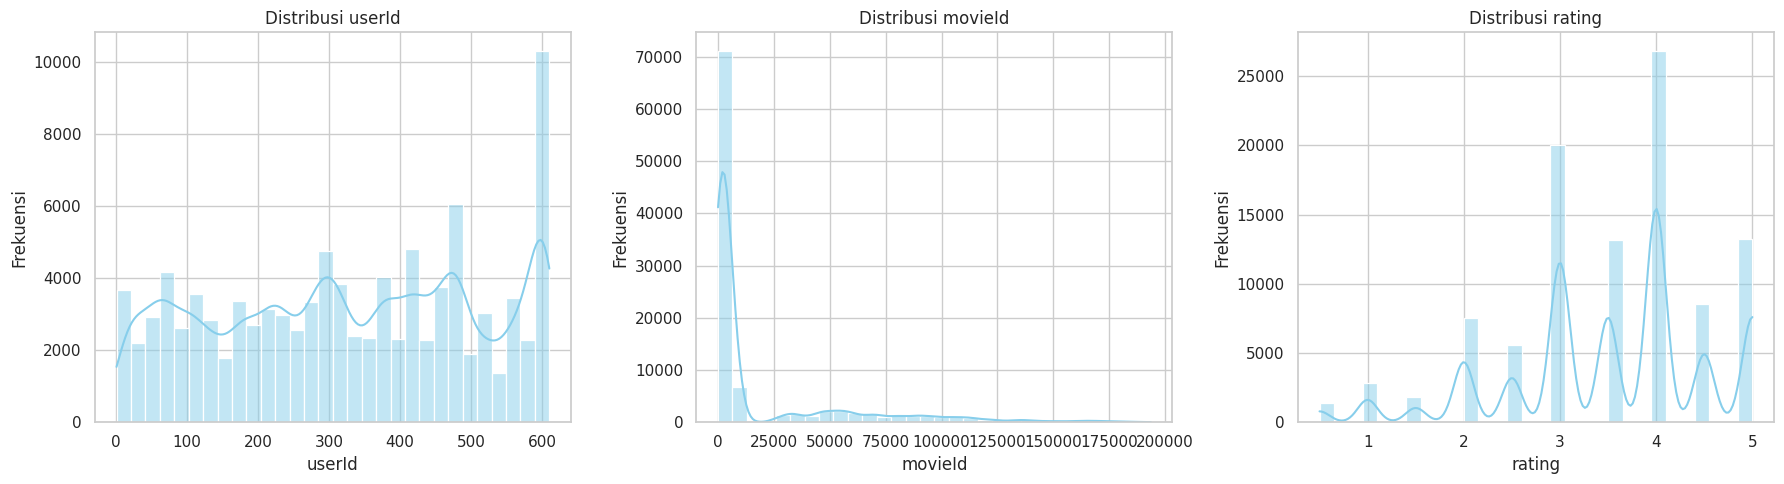

In [ ]:
sns.set(style="whitegrid")

# Buat subplot 1 baris 3 kolom
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop setiap kolom dan buat histogram-nya
for i, col in enumerate(cols):
    sns.histplot(data=ratings_df, x=col, bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribusi {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')

# Tata letak agar rapi
plt.tight_layout()
plt.show()

insight
- data movieId memiliki persebaran yang tidak merata dan sangat right-skewed, namun tidak dapat dikatakan bahwa data tersebut memiliki outlier

### Memeriksa data duplikat

In [ ]:
# jumlah data duplikat pada data movie
jumlah_duplikat_movie = movies_df.duplicated().sum()
print('Jumlah data duplikat pada data movie: ', jumlah_duplikat_movie)

# jumlah data duplikat pada data rating
jumlah_duplikat_rating = ratings_df.duplicated().sum()
print('Jumlah data duplikat pada data rating', jumlah_duplikat_rating)

Jumlah data duplikat pada data movie:  0
Jumlah data duplikat pada data rating 0


memeriksa keunikan data

In [ ]:
# Jumlah data unik di kolom title
unique_titles = movies_df['title'].nunique()
print('Jumlah judul unik:', unique_titles)

# Jumlah data unik di kolom movieId
unique_movieIds = movies_df['movieId'].nunique()
print('Jumlah movieId unik:', unique_movieIds)

Jumlah judul unik: 9737
Jumlah movieId unik: 9742


melihat letak data duplikat

In [ ]:
duplicates = movies_df.groupby('title')['movieId'].nunique()
duplicates = duplicates[duplicates > 1]
print(duplicates)

title
Confessions of a Dangerous Mind (2002)    2
Emma (1996)                               2
Eros (2004)                               2
Saturn 3 (1980)                           2
War of the Worlds (2005)                  2
Name: movieId, dtype: int64


insight :
- ditemukan data duplikat dimana sebuah judul film memiliki id yang berbeda

## Univariate Analysis

In [ ]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### Analisis Persebaran Genre Film

In [ ]:
# cek daftar genre
all_genres = movies_df['genres'].str.split('|').explode()

unique_genres = all_genres.unique()
print('Jumlah genre unik:', len(unique_genres))
print('Daftar genre unik:')
for genre in unique_genres:
    print('-', genre)

Jumlah genre unik: 20
Daftar genre unik:
- Adventure
- Animation
- Children
- Comedy
- Fantasy
- Romance
- Drama
- Action
- Crime
- Thriller
- Horror
- Mystery
- Sci-Fi
- War
- Musical
- Documentary
- IMAX
- Western
- Film-Noir
- (no genres listed)


menampilkan jumlah judul berdasarkan genre

Genre terbanyak:

genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


<ipython-input-21-2f9d20bda529>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


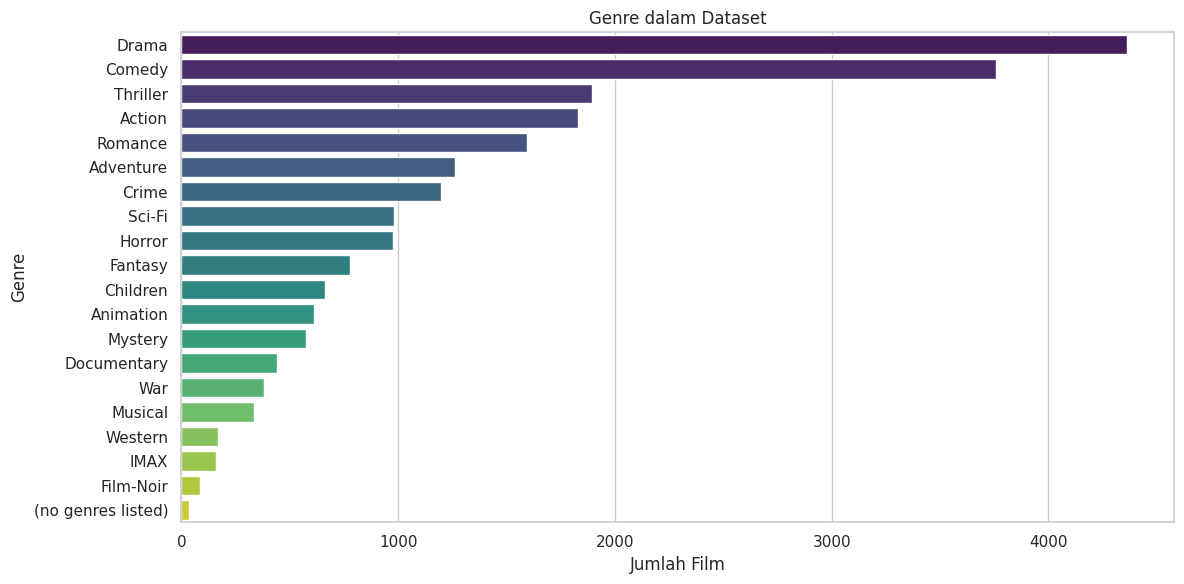

In [ ]:
# Visualisasi jumlah genre
genre_counts = all_genres.value_counts()

# Tampilkan  genre terbanyak
print("Genre terbanyak:\n")
print(genre_counts)
# Visualisasi dengan barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')

plt.title('Genre dalam Dataset')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

insight :
- terdapat 20 genre unik di dalam dataset.
- Drama adalah genre yang paling banyak muncul, diikuti oleh Comedy dan Thriller.
- Genre seperti Film-Noir dan Western tergolong langka.
- Terdapat 34 film tanpa genre yang tercantum, sehingga perlu dilakukan penghapusan karena model content based filtering yang akan dibangun berdasarkan genre.

### Analisis Persebaran Ratings Rating yang Diberikan Pengguna

<ipython-input-22-e2278c8c5e71>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='viridis')


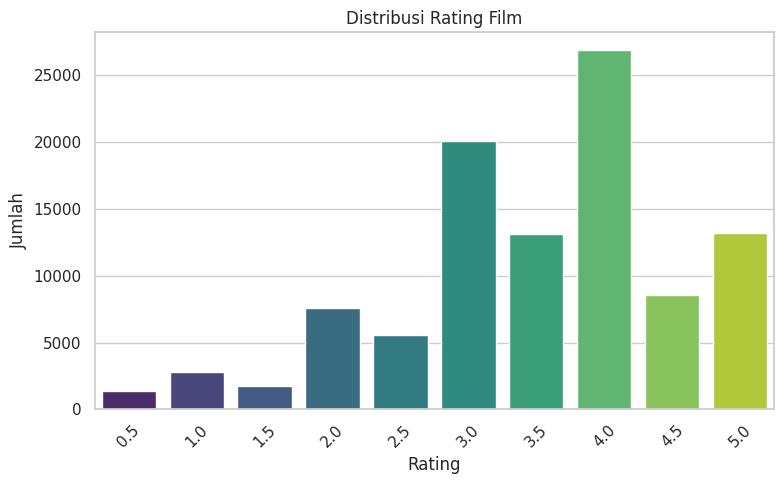

In [ ]:
# visualisasi persebaran ratings
sns.set(style="whitegrid")

# Ukuran figure
plt.figure(figsize=(8, 5))

# Plot distribusi rating
sns.countplot(x='rating', data=ratings_df, palette='viridis')

# Tambahkan judul dan label
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  # Rotasi label jika perlu

# Tampilkan plot
plt.tight_layout()
plt.show()

insight :
- Mayoritas pengguna cenderung memberikan rating moderat (antara 3.0 hingga 4.0), dengan 4.0 sebagai rating terbanyak.
- Rating sempurna (5.0) cukup sering diberikan pengguna jika dibandingkan dengan rating-rating rendah.

### Analisis Film yang Mendapatkan Rating Terbanyak

                                                  title  rating_count
314                                 Forrest Gump (1994)           329
277                    Shawshank Redemption, The (1994)           317
257                                 Pulp Fiction (1994)           307
510                    Silence of the Lambs, The (1991)           279
1938                                 Matrix, The (1999)           278
224           Star Wars: Episode IV - A New Hope (1977)           251
418                                Jurassic Park (1993)           238
97                                    Braveheart (1995)           237
507                   Terminator 2: Judgment Day (1991)           224
461                             Schindler's List (1993)           220
2224                                  Fight Club (1999)           218
0                                      Toy Story (1995)           215
897   Star Wars: Episode V - The Empire Strikes Back...           211
46                  

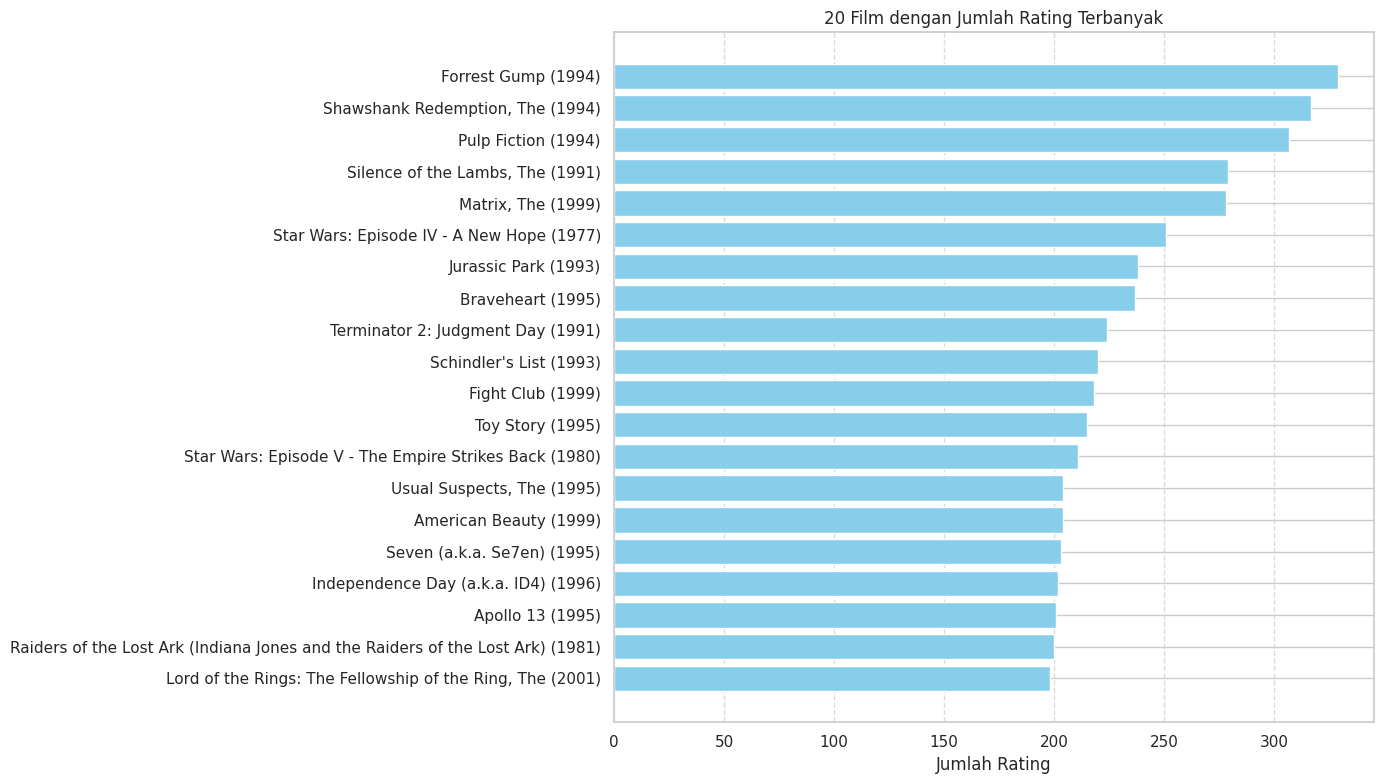

In [ ]:
# Hitung jumlah rating per film
rating_counts = ratings_df.groupby('movieId').size().reset_index(name='rating_count')

# Gabungkan dengan movies_df agar dapat judul film
movie_rating_counts = rating_counts.merge(movies_df[['movieId', 'title']], on='movieId')

# Urutkan berdasarkan rating_count terbesar dan ambil 20 teratas
top20_most_rated = movie_rating_counts.sort_values(by='rating_count', ascending=False).head(20)

print(top20_most_rated[['title', 'rating_count']])

# Visualisasi dengan bar chart
plt.figure(figsize=(14,8))
plt.barh(top20_most_rated['title'][::-1], top20_most_rated['rating_count'][::-1], color='skyblue')
plt.xlabel('Jumlah Rating')
plt.title('20 Film dengan Jumlah Rating Terbanyak')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


insight :
- sebagian besar film yang mendapatkan rating terbanyak dirilis pada tahun 1990-an.

In [ ]:
print('Jumlah userId unik: ', len(ratings_df.userId.unique()))
print('Jumlah movieId unik yang tersedia: ', len(movies_df.movieId.unique()))
print('Jumlah movieId unik yang dirating: ', len(ratings_df.movieId.unique()))
print('Jumlah data ratings: ', len(ratings_df))

Jumlah userId unik:  610
Jumlah movieId unik yang tersedia:  9742
Jumlah movieId unik yang dirating:  9724
Jumlah data ratings:  100836


# Data Preparation

## Data movie

Hapus baris yang kolom 'genres' berisi '(no genres listed)'

In [ ]:
# Hapus baris yang kolom 'genres' berisi '(no genres listed)'
fix_movie = movies_df[movies_df['genres'] != '(no genres listed)'].copy()

# Cek hasil
print(f"Sebelum: {len(movies_df)} baris")
print(f"Setelah: {len(fix_movie)} baris")


Sebelum: 9742 baris
Setelah: 9708 baris


menghapus judul film yang duplikat

In [ ]:
fix_movie = fix_movie.drop_duplicates(subset='title', keep='first')
duplicates = fix_movie.groupby('title')['movieId'].nunique()
duplicates = duplicates[duplicates > 1]
print(duplicates)

Series([], Name: movieId, dtype: int64)


menggabungkan data movies dan ratings untuk mendapatkan informasi mengenai film dan ratings

In [ ]:
merged_df = pd.merge(
    ratings_df,
    movies_df,
    on='movieId',
    how='left'
    )
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Data Preparation untuk algoritma Content-based Filtering

In [ ]:
# mengonversi setiap data series 'movieId' menjadi bentuk list
moviesId = fix_movie['movieId'].tolist()

# mengonversi data 'title' menjadi bentuk list
title = fix_movie['title'].tolist()

# mengonversi data 'genres' menjadi bentuk list
genres = fix_movie['genres'].tolist()

print(len(moviesId))
print(len(title))
print(len(genres))

9703
9703
9703


In [ ]:
# Membuat dictionary untuk data ‘moviesId’, ‘title’, dan ‘genres’
movies_new = pd.DataFrame({
    'moviesId': moviesId,
    'title': title,
    'genres': genres
})
movies_new

,moviesId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9698,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9699,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9700,193585,Flint (2017),Drama
9701,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


insight
- membuat dictionary untuk menentukan pasangan key-value pada data movies_id, title, dan genres

## Data preparation untuk Collaborative Filtering

copy data ratings ke dalam dataframe baru

In [ ]:
ratings_new = ratings_df.drop(columns=['timestamp'])
ratings_new.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


insight
- menghapus kolom timestamp karena tidak relevan untuk membangun sistem rekomendasi

Data Encoding dilakukan untuk mengubah nilai asli dari userId dan movieId menjadi bentuk numerik yang terurut (dari 0
hingga N-1), agar dapat digunakan sebagai input dalam model machine learning seperti embedding layer pada collaborative
filtering.

In [ ]:
# Encoding data userId
userIds = ratings_new['userId'].unique().tolist()
print('list userIds:', userIds)

user_to_user_encoded = {x: i for i, x in enumerate(userIds)}
print('encoded userIds : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(userIds)}
print('encoded angka ke userIds: ', user_encoded_to_user)

# encoding data movie
movieIds = ratings_new['movieId'].unique().tolist()
print('list movieIds:', movieIds)

movie_to_movie_encoded = {x: i for i, x in enumerate(movieIds)}
print('encoded movieID : ', movie_to_movie_encoded)

movie_encoded_to_movie = {i: x for i, x in enumerate(movieIds)}
print('encoded angka ke movieID: ', movie_encoded_to_movie)

list userIds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [ ]:
# menentukan jumlah user di dalam data ratings
num_users = len(userIds)
print('jumlah user:', num_users)

# menentukan jumlah film di dalam data ratings
num_movies = len(movieIds)
print('jumlah movie:', num_movies)

ratings_df['rating'] = ratings_df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(ratings_new['rating'])
max_rating = max(ratings_new['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

jumlah user: 610
jumlah movie: 9724
Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


alasan
- Kode ini berfungsi untuk menghitung jumlah user dan film unik serta menentukan rentang nilai rating, yang penting untuk mengatur ukuran embedding layer dan memastikan data rating memiliki tipe yang konsisten agar model rekomendasi dapat dilatih dengan benar. Informasi ini juga membantu dalam preprocessing seperti normalisasi agar model lebih stabil saat training.

In [ ]:
# mengacak kolom ratings
ratings_new = ratings_new.sample(frac=1, random_state=42)
ratings_new

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


alasan
- pengacakan data dilakukan agar model tidak memelajari data secara berurutan agar dapat memelajari data baru lebih baik

In [ ]:
# Mapping userID ke dataframe user
ratings_new['user'] = ratings_new['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
ratings_new['movie'] = ratings_new['movieId'].map(movie_to_movie_encoded)

X = ratings_new[['user', 'movie']]
y = ratings_new['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * ratings_new.shape[0])
X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(X, y)

       user  movie
67037   431   4730
42175   287    474
93850   598   2631
6187     41    194
12229    74    727
...     ...    ...
6265     41   1873
54886   363    524
76820   479   2240
860       5    712
15795   102   2046

[100836 rows x 2 columns] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


insight
- mendefinisikan kolom fitur dan terget
- melakukan spliting data dengan perbandingan 80 : 20. 80 digunakan untuk melakukan training model, dan 20 untuk evaluasi model.

# Model Deployment

## Model Content Based Filtering


In [ ]:
# membuat salinan dari data movies
data_movies = movies_new

### TF_IDF Vectorizer

In [ ]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(data_movies['genres'])

tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'western'], dtype=object)

insight
- Mengubah teks genre menjadi vektor numerik untuk mengubah setiap kumpulan genre (contohnya "Action|Adventure|Fantasy") menjadi vektor berdasarkan bobot TF-IDF (Term Frequency-Inverse Document Frequency).

In [ ]:
tfidf_matrix.shape

(9703, 21)

Konversi Sparse Matrix ke Dense Matrix

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.41679332, 0.51629181, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51228317, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57851656, 0.        , 0.81567064, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

insight
- Mengubah matrix TF-IDF dari format sparse menjadi format dense agar dapat diproses atau ditampilkan secara lengkap.









In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data_movies['title']
).sample(21, axis=1).sample(10, axis=0)

,film,romance,horror,drama,crime,western,sci,fi,musical,fantasy,...,imax,documentary,comedy,children,action,adventure,war,noir,animation,mystery
title,,,,,,,,,,,,,,,,,,,,,
American Ninja (1985),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.660021,0.751247,0.000000,0.0,0.000000,0.0
The Town that Dreaded Sundown (2014),0.0,0.000000,0.780942,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Igor (2008),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.459891,0.000000,0.000000,0.000000,0.000000,0.0,0.887975,0.0
Life (1999),0.0,0.000000,0.000000,0.441887,0.758802,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.478493,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Chicken Little (2005),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.394912,0.394912,0.0,0.000000,...,0.000000,0.0,0.233701,0.441282,0.320043,0.364278,0.000000,0.0,0.451240,0.0
"Ex, The (2007)",0.0,0.821319,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.570469,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Treasure Planet (2002),0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.357752,0.357752,0.0,0.000000,...,0.555174,0.0,0.000000,0.399759,0.000000,0.330001,0.000000,0.0,0.408780,0.0
"Big Year, The (2011)",0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
"Twilight Saga: New Moon, The (2009)",0.0,0.436665,0.512517,0.280094,0.000000,0.0,0.000000,0.000000,0.0,0.547875,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


### Cek Cosine Similarity

In [ ]:
# menggunakan subset 1000 film pertama untuk menghemat ram
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim.shape

(9703, 9703)

insight

- Menghitung similarity antar film berdasarkan fitur TF-IDF dari deskripsi atau metadata film.

- Mengurangi penggunaan memori dan mempercepat perhitungan dengan membatasi data hanya pada 1000 film pertama, karena menghitung similarity untuk seluruh dataset bisa sangat berat dan lambat jika dataset besar.

In [ ]:
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=data_movies['title'],
    columns=data_movies['title']
)

print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9703, 9703)


title,Land Before Time III: The Time of the Great Giving (1995),Blackboard Jungle (1955),Style Wars (1983),Crimson Peak (2015),"Road, The (2009)"
title,,,,,
Sunshine (2007),0.192384,0.280750,0.0,0.0,0.687160
Hell Ride (2008),0.000000,0.432710,0.0,0.0,0.555441
Charlotte's Web (2006),0.315178,0.313431,0.0,0.0,0.128058
Aileen: Life and Death of a Serial Killer (2003),0.000000,0.000000,1.0,0.0,0.000000
"Outlaw Josey Wales, The (1976)",0.170885,0.249378,0.0,0.0,0.610373
Igby Goes Down (2002),0.000000,0.678447,0.0,0.0,0.277191
Tombstone (1993),0.000000,0.300295,0.0,0.0,0.122690
New Jersey Drive (1995),0.000000,0.503235,0.0,0.0,0.205605
The Accountant (2016),0.000000,0.405203,0.0,0.0,0.520132


In [67]:
# Fungsi rekomendasi film berdasarkan cosine similarity
def movie_recommendations(title, similarity_data=cosine_sim_df, items=data_movies[['title', 'genres']], k=5):
    index = similarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

membangun fungsi untuk melakukan rekomendasi content based filtering

In [68]:
data_movies[data_movies.title.eq('Jumanji (1995)')]

,moviesId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [69]:
movie_recommendations('Jumanji (1995)')

,title,genres
0,Alice in Wonderland (1933),Adventure|Children|Fantasy
1,Seventh Son (2014),Adventure|Children|Fantasy
2,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
3,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure|Children|Fantasy
4,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children|Fantasy


mencoba melihat rekomendasi berdasarkan film 'Jumanji (1995)'

## Model Collaborative Filtering

In [65]:
class RecommenderNet(tf.keras.Model):

    # Inisialisasi fungsi
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # Embedding untuk pengguna
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Embedding untuk film
        self.movie_embedding = layers.Embedding(
            input_dim=num_movies,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        x = dot_user_movie + user_bias + movie_bias

        return tf.nn.sigmoid(x)

membangun model collaborative filtering dan mengcompile model

In [54]:
model = RecommenderNet(num_users, num_movies, embedding_size=50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=60,
    validation_data=(X_val, y_val)
)

Epoch 1/60
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.6461 - root_mean_squared_error: 0.2421 - val_loss: 0.6125 - val_root_mean_squared_error: 0.2060
Epoch 2/60
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.6063 - root_mean_squared_error: 0.1998 - val_loss: 0.6088 - val_root_mean_squared_error: 0.2017
Epoch 3/60
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.5996 - root_mean_squared_error: 0.1923 - val_loss: 0.6079 - val_root_mean_squared_error: 0.2006
Epoch 4/60
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5970 - root_mean_squared_error: 0.1893 - val_loss: 0.6072 - val_root_mean_squared_error: 0.1995
Epoch 5/60
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.5954 - root_mean_squared_error: 0.1862 - val_loss: 0.6069 - val_root_mean_squared_error: 0.1991
Epoch 6/60
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.5942 - root_mean_squared_error: 0.1858 - val_loss: 0.6068 - val_root_mean_squared_error: 0.1987
Epoch 7/60
10084/10084

melatih model

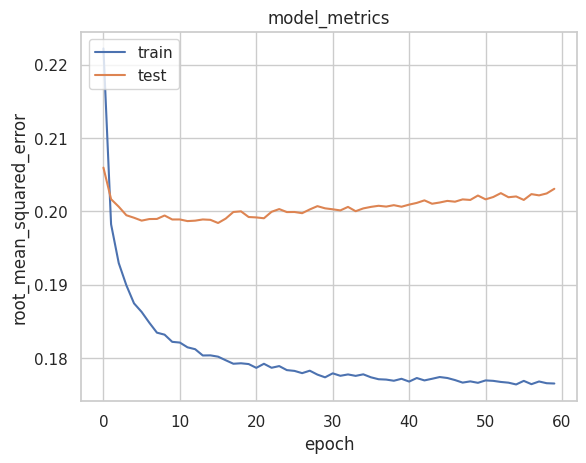

In [55]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

visualisasi grafik root mean square error

In [70]:
# Mengambil satu userId secara acak dari merged_df
user_id = merged_df['userId'].sample(1).iloc[0]

# Ambil semua movie yang sudah dirating oleh user ini
movies_watched_by_user = merged_df[merged_df.userId == user_id]

# Ambil semua movie yang belum ditonton oleh user ini
movies_not_watched = merged_df[~merged_df['movieId'].isin(movies_watched_by_user['movieId'].values)][['movieId']].drop_duplicates()

# Filter movieId yang ada di kamus encoding
movies_not_watched = movies_not_watched[movies_not_watched['movieId'].isin(movie_to_movie_encoded.keys())]

# Encoding movieId
movies_not_watched_encoded = [[movie_to_movie_encoded[x]] for x in movies_not_watched['movieId'].values]

# Encoding userId
user_encoded = user_to_user_encoded.get(user_id)

# Membuat array pasangan user dan semua film yang belum ditonton
user_movie_array = np.hstack((
    np.array([[user_encoded]] * len(movies_not_watched_encoded)),
    np.array(movies_not_watched_encoded)
))



In [71]:
# Prediksi rating
ratings = model.predict(user_movie_array).flatten()

# Ambil indeks top-10 prediksi tertinggi
top_indices = ratings.argsort()[-10:][::-1]

# Ambil movieId dari encoded
recommended_movie_ids = [
    movie_encoded_to_movie[i[0]] for i in np.array(movies_not_watched_encoded)[top_indices]
]

# Ambil judul dan genre film dari movieId rekomendasi
recommended_movies = merged_df[merged_df['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']].drop_duplicates()
print(recommended_movies)

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
       movieId                                              title  \
7400    170705                            Band of Brothers (2001)   
8729      6460                     Trial, The (Procès, Le) (1962)   
16258     1178                              Paths of Glory (1957)   
23008     3473  Jonah Who Will Be 25 in the Year 2000 (Jonas q...   
25413     7121                                  Adam's Rib (1949)   
27943       99               Heidi Fleiss: Hollywood Madam (1995)   
36049     4956                              Stunt Man, The (1980)   
49623    78836                              Enter the Void (2009)   
61503    26810                               Bad Boy Bubby (1993)   
64142     6442                                Belle époque (1992)   

                                               genres  
7400                                 Action|Drama|War  
8729                                            Drama  
16258                          

mencoba melihat rekomendasi berdasarkan film

# Evauation

## Model Content Based Filtering

** Precision**
**Precision** adalah matriks evaluasi kinerja model sistem rekomendasi yang mengukur seberapa banyak rekomendasi yang diberikan oleh sistem benar-benar relevan atau sesuai dengan preferensi pengguna. Secara matematis :

$$
\text{Precision} = \frac{\text{Jumlah item relevan yang direkomendasikan}}{\text{Jumlah total item yang direkomendasikan}}
$$

#### Alasan Memilih Precision sebagai Metrik Evaluasi

1. Fokus pada kualitas rekomendasi yang diberikan

   Precision menilai seberapa tepat rekomendasi yang muncul. Dalam konteks content-based filtering, rekomendasi yang akurat sangat penting agar pengguna merasa puas dan sistem dianggap bermanfaat.

2. Mudah dipahami dan diinterpretasikan

   Precision memberikan gambaran langsung berapa banyak rekomendasi yang benar-benar relevan dibanding total rekomendasi yang diberikan. Nilai precision yang tinggi menunjukkan kualitas rekomendasi yang baik.

3. Relevan untuk kasus rekomendasi dengan daftar terbatas

   Dalam banyak kasus, sistem rekomendasi hanya menampilkan sejumlah kecil item (misal top 5 atau top 10). Precision cocok digunakan untuk menilai performa dalam skala kecil tersebut.

4. Tidak bergantung pada total jumlah item relevan di database

   Berbeda dengan recall yang membutuhkan data lengkap tentang semua item relevan, precision hanya fokus pada hasil rekomendasi yang muncul. Ini memudahkan evaluasi terutama ketika data lengkap sulit diketahui.

#### Kesimpulan

Precision adalah metrik yang tepat digunakan untuk mengevaluasi sistem rekomendasi content-based filtering karena memberikan informasi jelas tentang proporsi rekomendasi yang benar-benar relevan bagi pengguna. Dengan memaksimalkan precision, kita dapat meningkatkan kepuasan pengguna terhadap rekomendasi yang diberikan.

---


In [66]:
target_genres = set(['Adventure', 'Children', 'Fantasy']) # target genre ganti berdasarkan genre film yang dicari

# mengambil rekomendasi
recommendations = movie_recommendations('Jumanji (1995)')

# Fungsi cek relevansi
def is_relevant(genre_str, target_genres):
    genres = set(genre_str.split('|'))
    return target_genres.issubset(genres)

# menghitung precision
total_recs = len(recommendations)
relevant_recs = recommendations['genres'].apply(lambda x: is_relevant(x, target_genres)).sum()

precision = relevant_recs / total_recs if total_recs > 0 else 0

print(f"Precision: {precision:.2f}")

Precision: 1.00


insight :
- sistem rekomendasi dengan Content-based filtering mencapai metric evaluasi precision sebesar 100%  
- nilai precision yang mencapai 100% menunjukkan bahwa algoitma yang dibangun berhasil merekomendasikan film berdasarkan genre dangan sangat akurat.

## Model Collaborative Filtering

**Root Mean Squared Error (RMSE)** dipilih sebagai metrik evaluasi untukmodel collaborative filtering ini. RMSE memberikan gambaran seberapa besar rata-rata kesalahan prediksi model dibandingkan rating asli dari pengguna, dengan satuan yang sama seperti rating.

Rumus RMSE:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2}
$$

di mana:

- $y_i$ adalah rating asli,
- $\hat{y}_i$ adalah rating prediksi,
- $N$ adalah jumlah data.

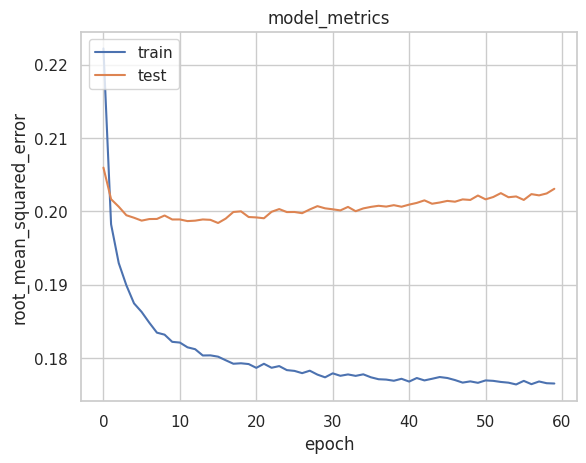

Final RMSE (Train): 0.1766
Final RMSE (Validation): 0.2031


In [59]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

final_rmse_train = history.history['root_mean_squared_error'][-1]
final_rmse_val = history.history['val_root_mean_squared_error'][-1]

print(f"Final RMSE (Train): {final_rmse_train:.4f}")
print(f"Final RMSE (Validation): {final_rmse_val:.4f}")


Insight
- Nilai Final RMSE (Train) sebesar 0.1766 menunjukkan bahwa model mampu memprediksi rating film dengan kesalahan rata-rata sekitar 0.18 poin pada data pelatihan. Ini menandakan model sudah belajar dengan baik dari data training.

- Nilai Final RMSE (Validation) sebesar 0.2031 menunjukkan performa model pada data yang belum pernah dilihat selama pelatihan. Nilai ini hanya sedikit lebih tinggi dibandingkan RMSE training, yang berarti model mampu melakukan generalisasi dengan baik dan tidak mengalami overfitting yang signifikan.

- Secara keseluruhan, nilai RMSE di bawah 0.3 pada skala rating 1–5 menunjukkan model memberikan prediksi yang cukup akurat dan dapat diandalkan untuk merekomendasikan film sesuai preferensi pengguna.

In [61]:
!pip freeze > requirements.txt